# Configuration Demo

### Load eICU CRD (Demo)

In [1]:
import sys; sys.path.append('../src')

from artemis.artemis import Artemis
from artemis.events import *
from artemis.thresholds import *

import seaborn as sns

path = '../../physionet.org/files/eicu-crd-demo/2.0.1'

artemis = Artemis(path, filter=lambda patient: patient.hospitalid == 59).load()

Loading database...


Computing virtual parameters: 0it [00:00, ?it/s]
Creating Patient objects: 100%|██████████| 13/13 [00:00<00:00, 73.19it/s]


### Comparison of Alarm Policies

In [2]:
def gender(patient, measurements, diagnoses, medications):
    if patient['gender'] == 'Female':
        return 125, 65
    elif patient['gender'] == 'Male':
        return 115, 55
    else: # gender unknown
        return 120, 60

def sepsis(patient, measurements, diagnoses, medications):
    if any(diagnoses.diagnosisstring.str.contains('sepsis')):
        return 140, 60
    else:
        return 120, 60

comp = artemis.compare('heartrate', [
    (fixed(120, 60), every),
    (offset(30, 30), every),
    (gender, every),
    (sepsis, every),
    (fixed(120, 60), delayed),
    (offset(30, 30), delayed),
    (gender, delayed),
    (sepsis, delayed),
    (fixed(120, 60), first),
    (offset(30, 30), first),
    (gender, first),
    (sepsis, first),
    (fixed(120, 60), second),
    (offset(30, 30), second),
    (gender, second),
    (sepsis, second),
    (fixed(120, 60), escalation),
    (offset(30, 30), escalation),
    (gender, escalation),
    (sepsis, escalation)])

comp

100%|██████████| 13/13 [00:56<00:00,  4.32s/it]


,Patient,Parameter,Alarm Threshold Policy,Alarm Event Policy,# High Alarms,# Low Alarms,# Alarms
0,Patient 223787,heartrate,"fixed(120, 60)",every,123,279,402
1,Patient 223787,heartrate,"offset(30, 30)",every,0,1800,1800
2,Patient 223787,heartrate,gender,every,141,146,287
3,Patient 223787,heartrate,sepsis,every,123,279,402
4,Patient 223787,heartrate,"fixed(120, 60)",delayed,111,261,372
...,...,...,...,...,...,...,...
255,Patient 141764,heartrate,sepsis,second,3,0,3
256,Patient 141764,heartrate,"fixed(120, 60)",escalation,6,0,6
257,Patient 141764,heartrate,"offset(30, 30)",escalation,1,0,1
258,Patient 141764,heartrate,gender,escalation,5,0,5


In [3]:
sums = comp.groupby(by=['Alarm Threshold Policy', 'Alarm Event Policy']).sum().reset_index()
sums

,Alarm Threshold Policy,Alarm Event Policy,# High Alarms,# Low Alarms,# Alarms
0,"fixed(120, 60)",delayed,144,551,695
1,"fixed(120, 60)",escalation,57,176,233
2,"fixed(120, 60)",every,168,598,766
3,"fixed(120, 60)",first,24,47,71
4,"fixed(120, 60)",second,17,31,48
5,gender,delayed,144,467,611
6,gender,escalation,60,162,222
7,gender,every,170,520,690
8,gender,first,26,53,79
9,gender,second,15,40,55


## Plotting

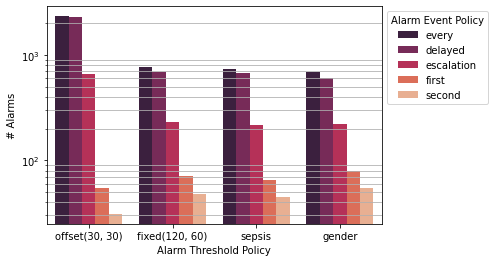

In [4]:
ax = sns.barplot(
    y='# Alarms',
    x='Alarm Threshold Policy',
    hue='Alarm Event Policy',
    data=sums,
    orient='v',
    palette='rocket',
    order=['offset(30, 30)', 'fixed(120, 60)', 'sepsis', 'gender'],
    hue_order=['every', 'delayed', 'escalation', 'first', 'second'])
ax.set_yscale('log')
ax.grid(visible=True, which='minor', axis='y')
ax.legend(title='Alarm Event Policy', loc='upper left', bbox_to_anchor=(1.0,1.0))

ax.get_figure().savefig(
    '../generated/side-by-side_comparison.pdf',
    bbox_inches='tight')